In [1]:
# Bachelorarbait-2021
# Author: Michel Bosris Djifack
# Matrikelnummer:7103963

In [2]:
# A sentiment analysis program will be designed to make predictions about the english written expressions to rank them and 
# determine which ones are in favor of the coronavirus vaccine and which are against.
# Method: NN (Neural Network)

# ===> Two classes (Binary) with NN

# NN-Prototype-2

In [3]:
"""
import all libraries (Math-function, diagram-visualisation, regex, document and NLP functions)

"""
# NLP Libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.metrics import accuracy_score,f1_score

# Math, documents and visualisation Libraries
import numpy as np
import preprocessor as p
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import colorama
from colorama import Fore

print(f"{Fore.MAGENTA}------------------- All libraries have been successfully imported.------------------- ")

------------------- All libraries have been successfully imported.------------------- 


In [4]:
"""
upload The dataset, open it and check it.

"""

# upload the DataSet
file = open('covidVaccineAdvice_mldata_d2.csv',encoding="utf-8")
data = pd.read_csv(file,delimiter=";")
print(f"{Fore.MAGENTA}------------------- The document has been successfully uploaded. ------------------- ")

------------------- The document has been successfully uploaded. ------------------- 


In [5]:
# Look at the document header.
print(f"{Fore.MAGENTA} -------------------  overview of the dataset ------------------- ")
data.head()

 -------------------  overview of the dataset ------------------- 


,id,message,sentiment
0,1,We need to be vaccinated to protect all person...,1
1,3,Negative,0
2,2,it is a pleasure to see how the govement are w...,1
3,6,I do not know what to think about vaccines as ...,0
4,4,The most popular vaccine that i know is Modern...,1


In [6]:
#count the data set
print(f"{Fore.MAGENTA} -------------------  The document has", data.shape[0], "rows and", data.shape[1],"columns ------------------- ")

 -------------------  The document has 1022 rows and 3 columns ------------------- 


In [7]:
# check missing values
count =data.isnull().sum().sort_values(ascending=False)
percentage =((data.isnull().sum()/len(data)*100)).sort_values(ascending=False)
missing_data =pd.concat([count,percentage],axis=1,keys=['count','Percentage'])

print(f"{Fore.MAGENTA}------------------- the number and percentage of missing values in the data set. ------------------- ")
missing_data

------------------- the number and percentage of missing values in the data set. ------------------- 


,count,Percentage
id,0,0.0
message,0,0.0
sentiment,0,0.0


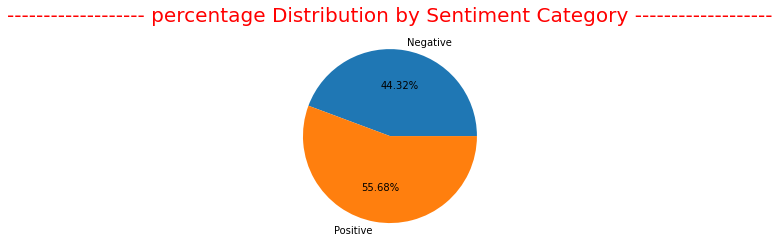

In [8]:
#check the Distributin of Sentiments
category = ['Negative','Positive']
values = [data.sentiment.astype(str).str.count(str(0)).sum(),data.sentiment.astype(str).str.count(str(1)).sum()]
plt.pie(values, labels= category,autopct ='%0.2f%%')
plt.title('------------------- percentage Distribution by Sentiment Category -------------------',fontsize=20,color='red')
plt.show()

In [9]:
"""
We will now clean the data by removing the special characters.

"""
#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})|(\=)|(\#)|(\§)")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")
print(f"{Fore.BLUE}------------------- Special characters and punctuation cleaning operations completed. ------------------- ")

------------------- Special characters and punctuation cleaning operations completed. ------------------- 


In [10]:
# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

print(f"{Fore.BLUE}------------------- preparation of the cleaning functions completed. ------------------- ")

------------------- preparation of the cleaning functions completed. ------------------- 


In [11]:
# Cleaning up tweets
clean_tweet = clean_tweets(data["message"])
print(f"{Fore.BLUE}------------------- The message cleaning operation is complete. ------------------- ")

------------------- The message cleaning operation is complete. ------------------- 


In [12]:
# append cleaned tweets to the training data
clean_tweet = pd.DataFrame(clean_tweet)
data["clean"] = clean_tweet
print(f"{Fore.BLUE}------------------- The clean data column has been successfully added to the dataset. ------------------- ")

------------------- The clean data column has been successfully added to the dataset. ------------------- 


In [13]:
# compare the cleaned and uncleaned tweets
print(f"{Fore.BLUE}------------------- overview of the dataset with the clean_data column. ------------------- ")
data.head()

------------------- overview of the dataset with the clean_data column. ------------------- 


,id,message,sentiment,clean
0,1,We need to be vaccinated to protect all person...,1,we need to be vaccinated to protect all person...
1,3,Negative,0,negative
2,2,it is a pleasure to see how the govement are w...,1,it is a pleasure to see how the govement are w...
3,6,I do not know what to think about vaccines as ...,0,i do not know what to think about vaccines as ...
4,4,The most popular vaccine that i know is Modern...,1,the most popular vaccine that i know is modern...


In [14]:
# The function who help to count unique words

def wordCount(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word]+=1
    return count

In [15]:
# count the number of unique words contained in the set of cleaned expressions. 
text= data.clean
counter = wordCount(text)
print(f"{Fore.BLUE}------------------- The column 'clean' contains: ",len(counter)," unique words ------------------- ")


------------------- The column 'clean' contains:  2570  unique words ------------------- 


In [16]:
"""
We will now define the maximum length of a sentence in terms of the number of words it can contain.
But first, we define the word count as the number of unique words.

"""

# define the number of words.
num_words = len(counter)
# maximum number of words in a sentence.
max_length = 42

print(f"{Fore.GREEN}------------------- Operations completed. ------------------- ")

------------------- Operations completed. ------------------- 


In [17]:
"""
In this section, we will divide the file (the 'clean' column) 
into two parts: one part for training and one part for testing.

X_train ==> train_sentences
X_test ==> test_sentences
y_train ==> train_labels
y_test ==> test_labels

"""
# train size 80% of the dataset
train_size= int(data.shape[0]*0.8)

# x_train ==> train_sentence
X_train = data.clean[:train_size]
y_train = data.sentiment[:train_size]

X_test = data.clean[:train_size]
y_test = data.sentiment[:train_size]

print(f"{Fore.GREEN}------------------- The data was successfully split. ------------------- ")

------------------- The data was successfully split. ------------------- 


In [18]:
"""
We will now tokenize the text ('clean' column):
This means that a unique number is associated with each unique word in the text.
"""

tokenizer = Tokenizer(num_words=num_words, split=" ")
tokenizer.fit_on_texts(X_train)
print(f"{Fore.GREEN}------------------- tokenization process complete. ------------------- ")

------------------- tokenization process complete. ------------------- 


In [19]:
# visualization of the result obtained after tokenization.

word_index = tokenizer.word_index
print(f"{Fore.GREEN}------------------- visualization of the result obtained after tokenization. ------------------- ")
print(f"{Fore.BLACK}",word_index)

------------------- visualization of the result obtained after tokenization. ------------------- 
 {'the': 1, 'to': 2, 'i': 3, 'vaccine': 4, 'not': 5, 'is': 6, 'of': 7, 'and': 8, 'a': 9, 'it': 10, 'vaccinated': 11, 'in': 12, 'vaccines': 13, 'for': 14, 'are': 15, 'be': 16, 'this': 17, 'that': 18, 'do': 19, 'get': 20, 'will': 21, 'covid': 22, 'have': 23, 'am': 24, 'we': 25, 'my': 26, 'so': 27, 'you': 28, 'all': 29, 'with': 30, 'as': 31, 'no': 32, 'but': 33, 'people': 34, 'us': 35, 'they': 36, 'if': 37, 'effects': 38, 'on': 39, 'or': 40, 'who': 41, 'can': 42, 'want': 43, 'side': 44, 'at': 45, 'vaccination': 46, 'take': 47, 'me': 48, '19': 49, 'about': 50, 'think': 51, 'there': 52, 'good': 53, 'these': 54, 'was': 55, 'more': 56, 'because': 57, 'first': 58, 'been': 59, 'against': 60, 'has': 61, 'should': 62, 'virus': 63, 'our': 64, 'when': 65, 'what': 66, 'by': 67, 'their': 68, 'does': 69, 'pfizer': 70, 'one': 71, 'why': 72, 'doses': 73, 'know': 74, 'lives': 75, 'let': 76, 'everyone': 77, '

In [20]:
"""
 Let's apply the tokenisation operation to each expression in column x. 
This will allow us to observe that each expression is identifiable by a group of numbers.
"""

train_sequences = tokenizer.texts_to_sequences(X_train)

In [21]:
# Let's see what the first three expressions of the document look like after the tokenisation operation.
print(data.clean[0])
print(f"{Fore.BLUE} first sentence. ===> ",data.clean[0])
print(f"{Fore.BLUE} first sentence. ===> ",train_sequences[0])

print(f"{Fore.GREEN} second sentence.  ===>",data.clean[1])
print(f"{Fore.BLUE} second sentence. ===> ",train_sequences[1])

print(f"{Fore.MAGENTA} third sentence.  ===> ",data.clean[2])
print(f"{Fore.BLUE} third sentence. ===> ",train_sequences[2])


we need to be vaccinated to protect all person around us
 first sentence. ===>  we need to be vaccinated to protect all person around us
 first sentence. ===>  [25, 102, 2, 16, 11, 2, 150, 29, 235, 310, 35]
 second sentence.  ===> negative
 second sentence. ===>  [236]
 third sentence.  ===>  it is a pleasure to see how the govement are working for our help i thing the vaccination is good for all of us
 third sentence. ===>  [10, 6, 9, 649, 2, 119, 97, 1, 1024, 15, 272, 14, 64, 215, 3, 108, 1, 46, 6, 53, 14, 29, 7, 35]


In [22]:
"""
We will try to transform each expression in the tokenizer to the length format defined above.
This allows us to have expressions of the same length.
"""

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

In [23]:
# Let's see what the first three expressions of the document look like after the operation.

print(f"{Fore.BLUE} first sentence. ===> ",train_padded[0])
print(f"{Fore.GREEN} second sentence.  ===>",train_padded[1])
print(f"{Fore.MAGENTA} third sentence.  ===> ",train_padded[2])

 first sentence. ===>  [ 25 102   2  16  11   2 150  29 235 310  35   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
 second sentence.  ===> [236   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
 third sentence.  ===>  [  10    6    9  649    2  119   97    1 1024   15  272   14   64  215
    3  108    1   46    6   53   14   29    7   35    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [24]:
# we repeat the same operations on the test sentences

"""
We will try to transform each expression in the tokenizer to the length format defined above.
This allows us to have expressions of the same length.
"""

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [25]:
# how our training data is dimensioned.
print(f"{Fore.BLUE} Shape of train. ===> ",{train_padded.shape})
print(f"{Fore.BLUE} Shape of train. ===> ",{test_padded.shape})
print(f"{Fore.GREEN} This means that 80% of the training data corresponds to 817 sentences of 42 words each. ")

 Shape of train. ===>  {(817, 42)}
 Shape of train. ===>  {(817, 42)}
 This means that 80% of the training data corresponds to 817 sentences of 42 words each. 


In [26]:
"""
We will now create a model that will be adapted to binary data. That is, with two labels, positive and negative

positive ==> 1
Negative ==> 0
"""

# create a Model
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(32, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=3e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 42, 32)            82240     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 90,593
Trainable params: 90,593
Non-trainable params: 0
_________________________________________________________________


In [27]:
# now we have to train the model 
model.fit(train_padded, y_train, epochs=20, verbose=2)
print(f"{Fore.GREEN}-------------------  The model was trained. ------------------- ")

Epoch 1/20
26/26 - 31s - loss: 0.6934 - accuracy: 0.5006
Epoch 2/20
26/26 - 0s - loss: 0.6930 - accuracy: 0.5116
Epoch 3/20
26/26 - 1s - loss: 0.6929 - accuracy: 0.5177
Epoch 4/20
26/26 - 1s - loss: 0.6928 - accuracy: 0.5226
Epoch 5/20
26/26 - 0s - loss: 0.6934 - accuracy: 0.5055
Epoch 6/20
26/26 - 1s - loss: 0.6922 - accuracy: 0.5410
Epoch 7/20
26/26 - 1s - loss: 0.6914 - accuracy: 0.5777
Epoch 8/20
26/26 - 0s - loss: 0.6778 - accuracy: 0.7381
Epoch 9/20
26/26 - 1s - loss: 0.5285 - accuracy: 0.7797
Epoch 10/20
26/26 - 1s - loss: 0.4176 - accuracy: 0.8384
Epoch 11/20
26/26 - 0s - loss: 0.3282 - accuracy: 0.8837
Epoch 12/20
26/26 - 0s - loss: 0.2602 - accuracy: 0.9168
Epoch 13/20
26/26 - 1s - loss: 0.2216 - accuracy: 0.9278
Epoch 14/20
26/26 - 0s - loss: 0.1761 - accuracy: 0.9547
Epoch 15/20
26/26 - 0s - loss: 0.1465 - accuracy: 0.9621
Epoch 16/20
26/26 - 1s - loss: 0.1276 - accuracy: 0.9670
Epoch 17/20
26/26 - 1s - loss: 0.1170 - accuracy: 0.9670
Epoch 18/20
26/26 - 0s - loss: 0.0983 -

In [28]:
"""
Now we test the model and we print the metrics data
"""

predictions = model.predict(test_padded)
y_pred = (predictions > 0.5)
print('Accuracy of the model : ', "%.2f" % (accuracy_score(y_pred, y_test)*100))
print("F1-score:  : ", "%.2f" %  (f1_score(y_pred, y_test)*100))

Accuracy of the model :  98.78
F1-score:  :  98.77


In [29]:
#Simulate the model with unknow values

# you cn write your own sentences on e and f nd check the result
a = ["a vaccine no i am not interested."]
b = ["There are times when I wonder why it is free. Anything that is free is dangerous. So i will never get it."]
c = ["I have my two doses and I am still alive. I am waiting for the others to find my freedom."]
d = ["Vaccination is very important. Also the vaccination against covid19."]

print(f"{Fore.GREEN}------------------- The simulation messages were successfully recorded.. ------------------- ")

------------------- The simulation messages were successfully recorded.. ------------------- 


In [30]:
# clean the values
clean_textA = clean_tweets(a)
clean_textB = clean_tweets(b)
clean_textC = clean_tweets(c)
clean_textD = clean_tweets(d)


print(f"{Fore.GREEN}------------------- The simulation messages cleaning operation is complete.. ------------------- ")

------------------- The simulation messages cleaning operation is complete.. ------------------- 


In [31]:
"""
We will try to transform each expression in the tokenizer to the length format defined above.
This allows us to have expressions of the same length.
"""
simulate_sentence_A = tokenizer.texts_to_sequences(clean_textA)
simulate_sentence_B = tokenizer.texts_to_sequences(clean_textB)
simulate_sentence_C = tokenizer.texts_to_sequences(clean_textC)
simulate_sentence_D = tokenizer.texts_to_sequences(clean_textD)



test_padded1 = pad_sequences(simulate_sentence_A, maxlen=max_length, padding='post', truncating='post')
test_padded2 = pad_sequences(simulate_sentence_B, maxlen=max_length, padding='post', truncating='post')
test_padded3 = pad_sequences(simulate_sentence_C, maxlen=max_length, padding='post', truncating='post')
test_padded4 = pad_sequences(simulate_sentence_D, maxlen=max_length, padding='post', truncating='post')



print(f"{Fore.BLUE} 1.sentence. ===> ",a)
print(f"{Fore.BLUE} 1.sentence. ===> ",test_padded1)

print(f"{Fore.GREEN} 2.sentence. ===> ",b)
print(f"{Fore.GREEN} 2.sentence. ===> ",test_padded2)

print(f"{Fore.RED} 3.sentence. ===> ",c)
print(f"{Fore.RED} 3.sentence. ===> ",test_padded3)

print(f"{Fore.BLACK} 4.sentence. ===> ",d)
print(f"{Fore.BLACK} 4.sentence. ===> ",test_padded4)

 1.sentence. ===>  ['a vaccine no i am not interested.']
 1.sentence. ===>  [[  9   4  32   3  24   5 363   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
 2.sentence. ===>  ['There are times when I wonder why it is free. Anything that is free is dangerous. So i will never get it.']
 2.sentence. ===>  [[ 52  15 537  65   3 321  72  10   6 115 358  18   6 115   6 791  27   3
   21  99  20  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
 3.sentence. ===>  ['I have my two doses and I am still alive. I am waiting for the others to find my freedom.']
 3.sentence. ===>  [[   3   23   26  107   73    8    3   24   95 1438    3   24  457   14
     1  185    2  172   26  463    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]
 4.sentence. ===>  ['Vaccination is very important. Also the vaccination a

In [32]:

pred1 = model.predict(test_padded1)
pred2 = model.predict(test_padded2)
pred3 = model.predict(test_padded3)
pred4 = model.predict(test_padded4)


print(f"{Fore.BLUE}------------------- Legend. ------------------- ")
print(f"{Fore.RED} 0  ===> negative.")
print(f"{Fore.RED} 1  ===> positive.")
print(f"{Fore.GREEN}#####################################################################################################")

print(f"{Fore.BLACK}%.f" % pred1," instead of Negative (0)")
print(f"{Fore.BLACK}%.f" % pred2," instead of Negative (0)")
print(f"{Fore.BLACK}%.f" % pred3," instead of Positive (1)")
print(f"{Fore.BLACK}%.f" % pred4," instead of Positive (1)")

------------------- Legend. ------------------- 
 0  ===> negative.
 1  ===> positive.
#####################################################################################################
0  instead of Negative (0)
0  instead of Negative (0)
1  instead of Positive (1)
1  instead of Positive (1)


In [33]:
print(f"{Fore.GREEN}------------------- The second NN prototype is completed. ------------------- ")

------------------- The second NN prototype is completed. ------------------- 
